# 📘 Lesson 3 — Linear Regression: Your First Machine Learning Model

---

### 🎯 Why this lesson matters
Up to now, we learned about **tensors** (data representation) and **gradients** (how learning happens).  
Now we put everything together in our **first real ML model: Linear Regression**.

👉 Why Linear Regression?
- Simple to visualize → just a straight line.
- Yet, it contains the **entire training pipeline**:
  - Data → Model → Loss → Gradient → Parameter Update.
- All deep learning models are built on the same idea:
  - Predict something.
  - Compare prediction with truth.
  - Use gradient descent to improve parameters.


In [1]:
# Setup
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)


## 1) What is Linear Regression?

The model is:

$
y = w \cdot x + b
$

- **w** = weight (slope of the line).
- **b** = bias (y-intercept).
- Our task: find the best **w** and **b** so that predictions fit the data.

👉 WHY?
Because most real-world problems (house price, salary, physics laws)  
can be *approximately* expressed as relationships between variables.


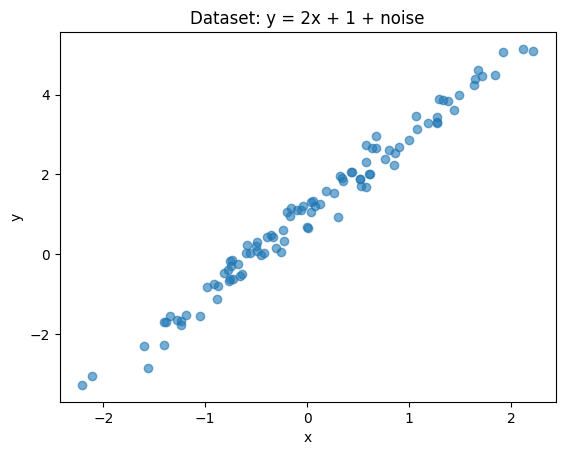

In [2]:
# Create synthetic dataset: y = 2x + 1 + noise
n_samples = 100
x = torch.randn(n_samples, 1)
true_w, true_b = 2.0, 1.0
noise = torch.randn(n_samples, 1) * 0.3
y = true_w * x + true_b + noise

plt.scatter(x.numpy(), y.numpy(), alpha=0.6)
plt.title("Dataset: y = 2x + 1 + noise")
plt.xlabel("x")
plt.ylabel("y")
plt.show()


## 2) Manual Implementation (from scratch)

Before using PyTorch’s helpers, let’s manually implement linear regression.  
This shows the **mechanics of learning**.

👉 WHY do this manually?
- To understand how gradients update parameters.
- To see what PyTorch automates for us later.


In [3]:
class LinearRegressionManual:
    def __init__(self):
        # Initialize w and b randomly
        self.w = torch.randn(1, requires_grad=True)
        self.b = torch.randn(1, requires_grad=True)

    def forward(self, x):
        return self.w * x + self.b

    def compute_loss(self, y_pred, y_true):
        return torch.mean((y_pred - y_true)**2)  # Mean Squared Error (MSE)

    def train_step(self, x, y, lr=0.01):
        y_pred = self.forward(x)
        loss = self.compute_loss(y_pred, y)

        # Reset gradients (avoid accumulation)
        if self.w.grad is not None: self.w.grad.zero_()
        if self.b.grad is not None: self.b.grad.zero_()

        # Compute gradients
        loss.backward()

        # WHY update like this?
        # Gradient points to direction of *increase*.
        # To minimize, we subtract gradient times learning rate.
        with torch.no_grad():
            self.w -= lr * self.w.grad
            self.b -= lr * self.b.grad

        return loss.item()


## 3) Training the Manual Model

We run multiple steps of gradient descent.  
At each step:
1. Make prediction.
2. Compute loss.
3. Compute gradient.
4. Update parameters.


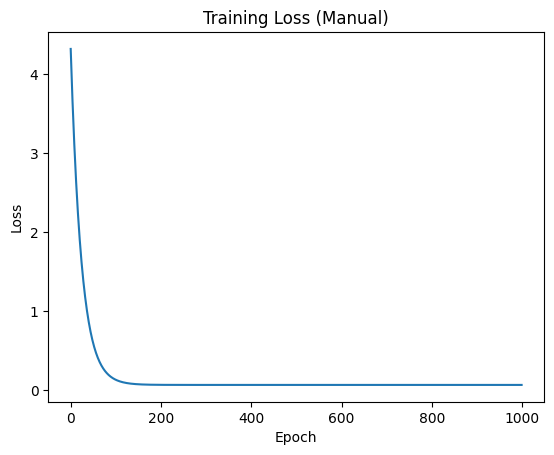

Learned params: 2.003537178039551 1.0107007026672363
True params: 2.0 1.0


In [4]:
model_manual = LinearRegressionManual()
losses = [model_manual.train_step(x, y, lr=0.01) for _ in range(1000)]

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (Manual)")
plt.show()

print("Learned params:", model_manual.w.item(), model_manual.b.item())
print("True params:", true_w, true_b)


## 4) Visualization — WHY is this useful?

Numbers (loss) decrease, but visualization proves the model **fits the data**.  
Without plotting, you may have a low loss but wrong intuition.


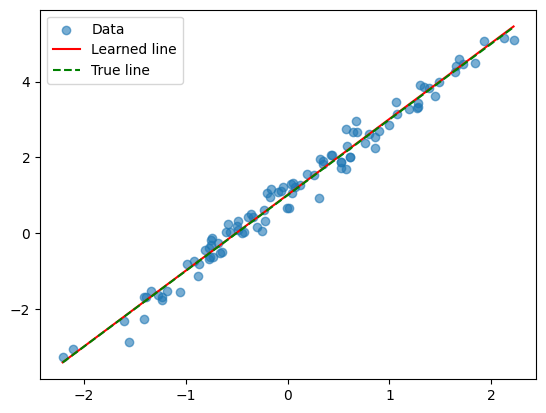

In [5]:
def plot_fit(x, y, model, true_w, true_b):
    plt.scatter(x.numpy(), y.numpy(), alpha=0.6, label="Data")
    x_line = torch.linspace(x.min(), x.max(), 100).unsqueeze(1)
    with torch.no_grad():
        y_line = model.forward(x_line)
    plt.plot(x_line.numpy(), y_line.numpy(), "r-", label="Learned line")

    y_true_line = true_w * x_line + true_b
    plt.plot(x_line.numpy(), y_true_line.numpy(), "g--", label="True line")
    plt.legend()
    plt.show()

plot_fit(x, y, model_manual, true_w, true_b)


## 5) Using PyTorch `nn.Module`

Manual training works, but it’s not scalable.  
PyTorch provides ready-made tools.

👉 WHY use `nn.Linear`?
- It stores weights and bias automatically.
- Works with optimizers.
- Prepares us for deep neural networks.


In [6]:
class LinearRegressionPyTorch(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)  # one input → one output

    def forward(self, x):
        return self.linear(x)

model_pt = LinearRegressionPyTorch()
criterion = nn.MSELoss()
optimizer = optim.SGD(model_pt.parameters(), lr=0.01)


## 6) Training Loop in PyTorch

Steps are always:

**Forward → Loss → Backward → Update**

👉 WHY always this order?
- Forward: simulate prediction.  
- Loss: compare prediction vs target.  
- Backward: gradients tell us how to change parameters.  
- Update: optimizer applies the changes.


In [7]:
epochs = 1000
losses_pt = []
for epoch in range(epochs):
    y_pred = model_pt(x)
    loss = criterion(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_pt.append(loss.item())


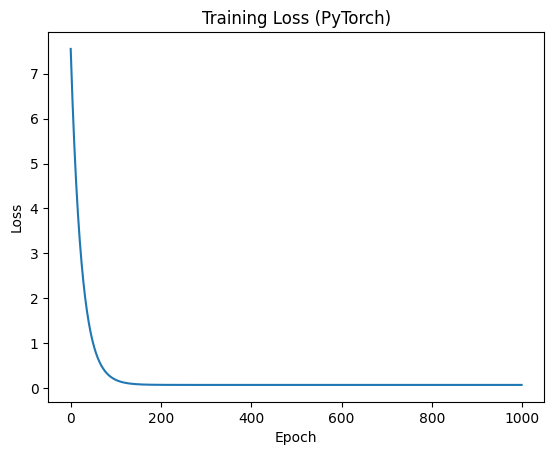

In [8]:
plt.plot(losses_pt)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (PyTorch)")
plt.show()


## 7) Comparing Manual vs PyTorch Models

Both approaches should converge near the true parameters.


In [9]:
print("Manual params:", model_manual.w.item(), model_manual.b.item())
print("PyTorch params:", list(model_pt.parameters()))
print("True params:", true_w, true_b)


Manual params: 2.003537178039551 1.0107007026672363
PyTorch params: [Parameter containing:
tensor([[2.0035]], requires_grad=True), Parameter containing:
tensor([1.0107], requires_grad=True)]
True params: 2.0 1.0


## 8) Real-world Example: Housing Prices

Linear regression is not just theory.  
Example: Predict house prices from size.

👉 WHY relevant?  
Because most business applications start with regression models.


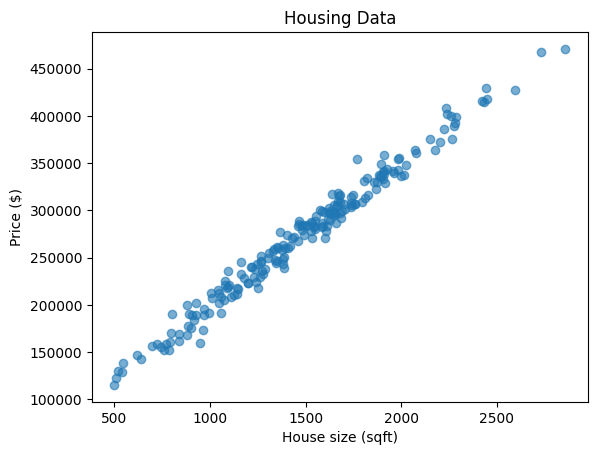

In [10]:
np.random.seed(42)
house_size = np.random.normal(1500, 500, 200)
house_size = np.clip(house_size, 500, 3000)
price = 150 * house_size + 50000 + np.random.normal(0, 10000, 200)

X = torch.FloatTensor(house_size).unsqueeze(1)
y_house = torch.FloatTensor(price).unsqueeze(1)

plt.scatter(X.numpy(), y_house.numpy(), alpha=0.6)
plt.xlabel("House size (sqft)")
plt.ylabel("Price ($)")
plt.title("Housing Data")
plt.show()


## 9) Multi-Feature Regression

Real life is rarely 1D.  
Example: price depends on size, location, number of rooms…

👉 WHY multi-feature?  
Because neural networks are just many linear regressions stacked.


In [11]:
from sklearn.datasets import make_regression

X_multi, y_multi = make_regression(n_samples=200, n_features=3, noise=0.1, random_state=42)
X_multi = torch.FloatTensor(X_multi)
y_multi = torch.FloatTensor(y_multi).unsqueeze(1)

multi_model = nn.Linear(3, 1)
optimizer = optim.SGD(multi_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(500):
    y_pred = multi_model(X_multi)
    loss = criterion(y_pred, y_multi)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


## 10) Best Practices — WHY they matter

- Normalize input → avoids exploding numbers.  
- Pick learning rate carefully → too high = divergence, too low = slow learning.  
- Reset gradients (`zero_grad()`) → prevent accumulation.  
- Plot training curve → detect if training is stuck.

👉 These are universal rules you’ll use in *all ML projects*.


## ✅ Summary

- Linear Regression is our **first ML model**.
- It taught us:
  1. Data preparation.
  2. Model definition (manual vs PyTorch).
  3. Loss function to measure error.
  4. Gradient descent to update parameters.
- Every deep learning model is an extension of this training loop.

